In [1]:
import torch
import torch.nn as nn
import torch.nn.utils
import torch.optim as optim
from torch.nn import CrossEntropyLoss
import torch.nn.functional as F
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.nn.parameter import Parameter
import math
import numpy as np
import pandas as pd
import random
import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, f1_score
pd.options.display.max_rows = None
pd.options.display.max_columns = None

In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

print(f'GPU available: {torch.cuda.is_available()}')

Fri Dec 10 02:15:36 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
#%% read the data (this is the way to read the input column as list of strings)
train = pd.read_csv("complaints_train.csv", converters={"input": lambda x: x.strip("[]").replace("'","").split(", ")})
test = pd.read_csv("complaints_test.csv", converters={"input": lambda x: x.strip("[]").replace("'","").split(", ")})
print(train.head(5))
print(test.head(5))

                                               input  label
0  [began, charg, addit, per, month, call, even, ...      6
1  [file, document, inaccurate, unknown, account,...      3
2  [request, document, bureau, file, contain, wet...      3
3  [account, longer, active, remov, credit, repor...      3
4  [due, job, loss, husband, unable, pay, credit,...      3
                                               input  label
0  [sent, letter, day, ago, request, incorrect, i...      3
1  [ny, social, secur, dob, herebi, make, ghostle...      4
2  [contract, longer, able, view, account, online...      4
3  [repeat, call, compani, say, tri, collect, deb...      4
4  [move, tri, change, internet, new, address, to...      4


In [4]:
print(len(train))
print(len(test))

140336
35085


In [5]:
#%% build word count
sentences_train = train["input"].tolist()
sentences_test = test["input"].tolist()
labels_train = train["label"].tolist()
labels_test = test["label"].tolist()

In [6]:
def shorten_word_list(sentences, max_len):
    shortened_sentences = []
    for sentence in sentences:
        if max_len >= len(sentence):
            shortened_sentences.append(sentence)
        else:
            shortened_sentences.append(sentence[:max_len])
    return shortened_sentences

In [7]:
from collections import Counter
wordCounts = Counter([w for l in sentences_train for w in l])
print(wordCounts)
print(len(wordCounts))
singletons = set([w for (w,c) in wordCounts.items() if c == 1])
print(singletons)
print(len(singletons))

def find_max_min_avg_list(lst):
    lst_len = [len(i) for i in lst]
    print(max(lst_len))
    print(min(lst_len))
    print(sum(lst_len)/len(lst_len))

print(find_max_min_avg_list(sentences_train))

Counter({'account': 264717, 'credit': 261727, 'report': 261158, 'inform': 125795, 'payment': 100916, 'call': 88215, 'debt': 75123, 'day': 73036, 'time': 71553, 'compani': 67551, 'receiv': 65986, 'consum': 63910, 'bank': 63686, 'letter': 62864, 'request': 61948, 'would': 61069, 'loan': 58992, 'card': 56850, 'sent': 56450, 'collect': 56150, 'state': 53497, 'file': 52477, 'also': 48679, 'dispute': 48383, 'never': 47133, 'told': 46650, 'get': 46649, 'contact': 45185, 'bureau': 44683, 'number': 44256, 'date': 43812, 'ask': 42068, 'back': 40784, 'due': 39614, 'please': 38473, 'month': 37525, 'pay': 37108, 'ident': 37106, 'document': 36936, 'one': 36904, 'agenc': 36298, 'amount': 35928, 'close': 35847, 'balance': 35552, 'need': 35439, 'use': 35266, 'check': 35239, 'item': 34982, 'inquiri': 34601, 'money': 34174, 'still': 33650, 'open': 33418, 'paid': 32932, 'theft': 32878, 'violat': 32846, 'made': 32786, 'person': 32418, 'name': 31871, 'late': 31871, 'email': 31847, 'remov': 31779, 'said': 31

In [8]:
sentences_train = shorten_word_list(sentences_train, max_len = 300)
print(find_max_min_avg_list(sentences_train))

300
1
73.96948751567666
None


In [9]:
#%% map word to index
word2i = {w:i+2 for i,w in enumerate(set([w for l in sentences_train for w in l]))}
i2word = {i:w for w,i in word2i.items()}

#When training, randomly replace singletons with UNK tokens sometimes to simulate situation at test time.
def getDictionaryRandomUnk(w, dictionary, train = False):
  if train and (w in singletons and random.random() > 0.5):
    return 1
  else:
    return dictionary.get(w, 1)

#Map a list of sentences from words to indices.
def sentences2indices(words, dictionary, train=False):
  return [[getDictionaryRandomUnk(w,dictionary, train=train) for w in l] for l in words]

In [10]:
def prepare_input(X_list): # input: list
    X_padded = torch.nn.utils.rnn.pad_sequence([torch.as_tensor(l) for l in X_list], batch_first = True).type(torch.LongTensor)
    X_mask   = torch.nn.utils.rnn.pad_sequence([torch.as_tensor([1.0] * len(l)) for l in X_list], batch_first = True).type(torch.FloatTensor)
    return (X_padded, X_mask)

def prepare_label(Y_list): # input: list
    label = torch.from_numpy(np.array((Y_list)))
    return torch.autograd.Variable(label).long()

In [11]:
def read_glove(glove_fn):
    GloVe = {}
    for line in open(glove_fn, encoding = "utf-8").readlines():
        fields = line.strip().split(" ")
        word = fields[0]
        GloVe[word] = [float(x) for x in fields[1:]]
    return GloVe

def shuffle_sentences(sentences, tags):
    shuffled_sentences = []
    shuffled_tags      = []
    indices = list(range(len(sentences)))
    random.shuffle(indices)
    for i in indices:
        shuffled_sentences.append(sentences[i])
        shuffled_tags.append(tags[i])
    return (shuffled_sentences, shuffled_tags)

In [12]:
class CompositionalEmbedding(nn.Module):
    def __init__(self, num_embedding, embedding_dim, num_codebook, num_codeword = True, num_repeat = 10):
        super(CompositionalEmbedding, self).__init__()
        self.num_embedding = num_embedding
        self.emb_dim = embedding_dim
        self.num_codebook = num_codebook
        self.num_repeat = num_repeat

        if num_codeword is None:
            num_codeword = math.ceil(math.pow(num_embedding, 1 / num_codebook))
        self.num_codeword = num_codeword
        self.code = Parameter(torch.Tensor(num_embedding, num_codebook, num_codeword))
        self.codebook = Parameter(torch.Tensor(num_codebook, num_codeword, embedding_dim))

        nn.init.normal_(self.code)
        nn.init.normal_(self.codebook)

    def forward(self, X):
        batch_size = X.size(0)
        index = X.view(-1)
        code = self.code.index_select(dim = 0, index = index)
        code = F.softmax(code, dim = -1)
        out= (code[:,:, None,:] @ self.codebook[None, :, :, :]).squeeze(dim = -2).sum(dim = 1)
        out = out.view(batch_size, -1, self.emb_dim)
        code = code.view(batch_size, -1, self.num_codebook, self.num_codeword)
        return out

In [13]:
def k_means_routing(input, num_iterations = 3):
    output = input.sum(dim=-2, keepdim=True) / input.size(-3)
    for r in range(num_iterations):
        logits = (input * F.normalize(output, p=2, dim=-1)).sum(dim=-1, keepdim=True)
        probs = F.softmax(logits, dim=-3)
        output = (probs * input).sum(dim=-2, keepdim=True)
    return output.squeeze(dim=-2), probs.squeeze(dim=-1)

In [14]:
def capsule_linear(input, weight, num_iterations = 3, **kwargs):
    priors = (weight.unsqueeze(dim = 1).unsqueeze(dim = 0) @ input.unsqueeze(dim = 1).unsqueeze(dim = -1)).squeeze(dim = -1)
    out, probs = k_means_routing(priors, num_iterations, **kwargs)
    return out, probs

In [15]:
class CapsuleLinear(nn.Module):
    def __init__(self, out_capsules, in_length, out_length, in_capsules = None, num_iterations=3, **kwargs):
        super(CapsuleLinear, self).__init__()
        self.out_capsules = out_capsules
        self.in_capsules = in_capsules
        self.num_iterations = num_iterations
        self.kwargs = kwargs
        self.weight = Parameter(torch.Tensor(out_capsules, out_length, in_length))

        nn.init.xavier_uniform_(self.weight)

    def forward(self, input):
        return capsule_linear(input, self.weight, self.num_iterations, **self.kwargs)

In [16]:
class CapsuleNet(nn.Module):
    def __init__(self, embedding_size, num_codebook, num_codeword, hidden_size, in_length, out_length, num_class, num_iterations, dropout):
        super().__init__()

        self.vocab_size = max(word2i.values()) + 2
        self.in_length, self.out_length = in_length, out_length
        self.hidden_size = hidden_size
        self.embedding = CompositionalEmbedding(self.vocab_size, embedding_size, num_codebook, num_codeword)
        self.features = nn.GRU(embedding_size, self.hidden_size, num_layers = 2, dropout = dropout, batch_first = True, bidirectional = True)
        self.classifier = CapsuleLinear(out_capsules = num_class, in_length = self.in_length, out_length = self.out_length, in_capsules = None, num_iterations = num_iterations)
    
    def forward(self, X, X_mask):
        embed = self.embedding(X)
        seq_len = [int(X_mask[k].sum().item()) for k in range(len(X))]
        max_seq_len = embed.shape[1]
        embed_packed = pack_padded_sequence(embed, seq_len, batch_first = True, enforce_sorted = False)
        gru_packed, _  = self.features(embed_packed)
        gru_padded, _  = pad_packed_sequence(gru_packed, total_length = max_seq_len, batch_first = True)
        gru_out = gru_padded[:, :, : self.hidden_size] + gru_padded[:,:, self.hidden_size:]
        gru_out = gru_out.mean(dim = 1).contiguous()
        gru_out = gru_out.view(gru_out.size(0), -1, self.in_length)
        out = self.classifier(gru_out)[0]
        classes = out.norm(dim = -1)
        return classes

In [17]:
def train_model(sentences, labels, model,  loss_type, num_class, max_len = 300):
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr = 0.01)
    batchSize = 128
    total_train_loss = 0
    total_train_numcorrect = 0
    sentences = shorten_word_list(sentences, max_len = max_len)
    if torch.cuda.is_available():
        model.cuda()
    model.train()
    for batch in tqdm.notebook.tqdm(range(0, len(sentences), batchSize), leave = False):
        X = sentences2indices(sentences[batch:batch + batchSize], word2i, train = True)
        X_padded = prepare_input(X)[0]
        X_mask = prepare_input(X)[1]
        Y = prepare_label(labels[batch:batch + batchSize])
        if torch.cuda.is_available():
            X_padded = X_padded.cuda()
            Y = Y.cuda()
        model.zero_grad()
        pred = model(X_padded, X_mask)
        loss = F.cross_entropy(pred, Y)
        num_corrects = sum(pred.argmax(axis = 1) == Y)
        total_train_loss += loss.item()
        total_train_numcorrect += num_corrects.item()
        loss.backward()
        optimizer.step()
    return total_train_loss/len(sentences), total_train_numcorrect/len(sentences)

In [18]:
def plot_epoch_loss(epochs, train_loss, val_loss):
    fig, ax = plt.subplots(figsize=(10, 10))
    plt.title("Train/Validation Loss", fontsize = 20, fontweight = "bold")
    plt.plot(list(np.arange(epochs) + 1) , train_loss, label = 'train')
    plt.plot(list(np.arange(epochs) + 1), val_loss, label = 'validation')
    plt.xticks(fontsize = 16)
    plt.yticks(fontsize = 16)
    plt.xlabel('num_epochs', fontsize=18, fontweight = "bold")
    plt.ylabel('loss', fontsize=18, fontweight = "bold")
    plt.legend(loc='best', prop={'size': 18, 'weight': 'bold'})
    plt.show()
    plt.savefig("Learning Curve.png", dpi=400)

def plot_confusion_matrix(true_label, pred_val, ticklabels):
    pred_label = list(pred_val.argmax(axis = 1))
    fig, ax = plt.subplots(figsize=(10, 10))
    cm = confusion_matrix(true_label, pred_label)
    sns.heatmap(cm, annot = True, cbar = False,
                fmt = '1d', cmap = 'Blues', ax = ax, annot_kws={"size": 24, 'weight': 'bold'},
                xticklabels = ticklabels, yticklabels = ticklabels)
    plt.xticks(weight = 'bold', rotation = 90)
    plt.yticks(weight = 'bold')
    ax.tick_params(axis = 'both', which = 'major', labelsize = 28)
    ax.set_xlabel('Predicted Class', fontsize = 28, fontweight = "bold")
    ax.set_ylabel('Actual News Class', fontsize = 28, fontweight = "bold")
    plt.show()
    plt.savefig("Confusion Matrix.png", dpi=400)
    print("The F1 score of validation set is {}". format(f1_score(true_label, pred_label, average='weighted')))

In [19]:
def eval_model(sentences, labels, model, num_class, max_len = 300):
    total_val_loss = 0
    total_val_numcorrect = 0
    if torch.cuda.is_available():
        model.cuda()
    model.eval()
    batchSize = 128
    sentences = shorten_word_list(sentences, max_len)
    val_preds = np.zeros((len(sentences), num_class))
    with torch.no_grad():
        for batch in tqdm.notebook.tqdm(range(0, len(sentences), batchSize), leave = False):
            X = sentences2indices(sentences[batch:batch + batchSize], word2i, train = False)
            X_padded = prepare_input(X)[0]
            X_mask = prepare_input(X)[1]
            Y = prepare_label(labels[batch:batch + batchSize])
            if torch.cuda.is_available():
                X_padded = X_padded.cuda()
                Y = Y.cuda()
                model = model.cuda()
            pred = model(X_padded, X_mask)
            loss = F.cross_entropy(pred, Y)
            num_corrects = sum(pred.argmax(axis = 1) == Y)
            total_val_loss += loss.item()
            total_val_numcorrect += num_corrects.item()
            val_preds[batch : batch + batchSize] = (pred).cpu().numpy()
    return total_val_loss/len(sentences), total_val_numcorrect/len(sentences), val_preds

In [20]:
model = CapsuleNet(embedding_size = 64, num_codebook = 8, num_codeword = None, hidden_size = 128, in_length = 8, out_length = 16, num_class = 7, num_iterations = 3, dropout = 0)
nEpoch = 5

In [21]:
print(model)

CapsuleNet(
  (embedding): CompositionalEmbedding()
  (features): GRU(64, 128, num_layers=2, batch_first=True, bidirectional=True)
  (classifier): CapsuleLinear()
)


In [22]:
train_loss_lst = []
val_loss_lst = []
for epoch in range(nEpoch):
    (sentences_shuffled, labels_shuffled) = shuffle_sentences(sentences_train, labels_train)
    train_loss, train_acc = train_model(sentences_shuffled, labels_shuffled, model, loss_type = 'cross_entropy', num_class = 7)
    val_loss, val_acc, val_preds = eval_model(sentences_test, labels_test, model, num_class = 7)
    print(f'Epoch: {epoch+1:02}, Train Loss: {train_loss:.3f}, Train Acc: {train_acc:.4f}, Val. Loss: {val_loss:3f}, Val. Acc: {val_acc:.4f}')
    train_loss_lst.append(train_loss)
    val_loss_lst.append(val_loss)

  0%|          | 0/1097 [00:00<?, ?it/s]

  0%|          | 0/275 [00:00<?, ?it/s]

Epoch: 01, Train Loss: 0.008, Train Acc: 0.6929, Val. Loss: 0.007025, Val. Acc: 0.7600


  0%|          | 0/1097 [00:00<?, ?it/s]

  0%|          | 0/275 [00:00<?, ?it/s]

Epoch: 02, Train Loss: 0.006, Train Acc: 0.7887, Val. Loss: 0.005023, Val. Acc: 0.7975


  0%|          | 0/1097 [00:00<?, ?it/s]

  0%|          | 0/275 [00:00<?, ?it/s]

Epoch: 03, Train Loss: 0.005, Train Acc: 0.8070, Val. Loss: 0.004414, Val. Acc: 0.8169


  0%|          | 0/1097 [00:00<?, ?it/s]

  0%|          | 0/275 [00:00<?, ?it/s]

Epoch: 04, Train Loss: 0.004, Train Acc: 0.8237, Val. Loss: 0.004486, Val. Acc: 0.8196


  0%|          | 0/1097 [00:00<?, ?it/s]

  0%|          | 0/275 [00:00<?, ?it/s]

Epoch: 05, Train Loss: 0.004, Train Acc: 0.8303, Val. Loss: 0.004185, Val. Acc: 0.8302


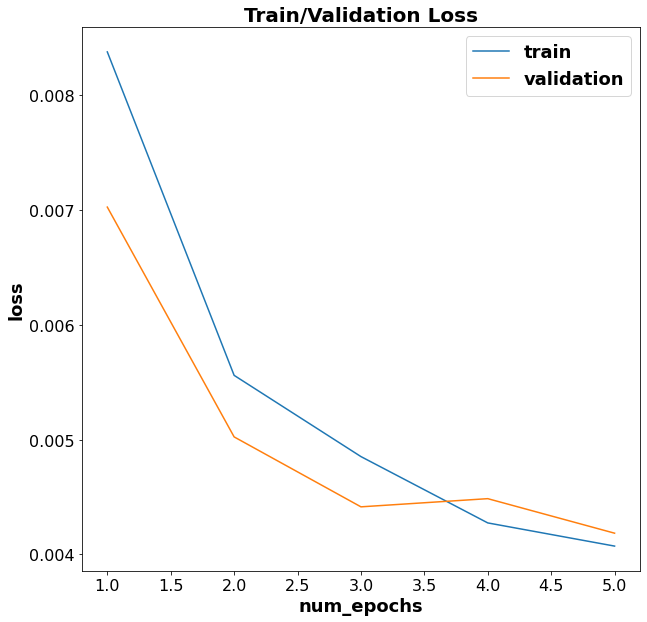

<Figure size 432x288 with 0 Axes>

In [25]:
from google.colab import files
plot_epoch_loss(nEpoch, train_loss_lst, val_loss_lst)

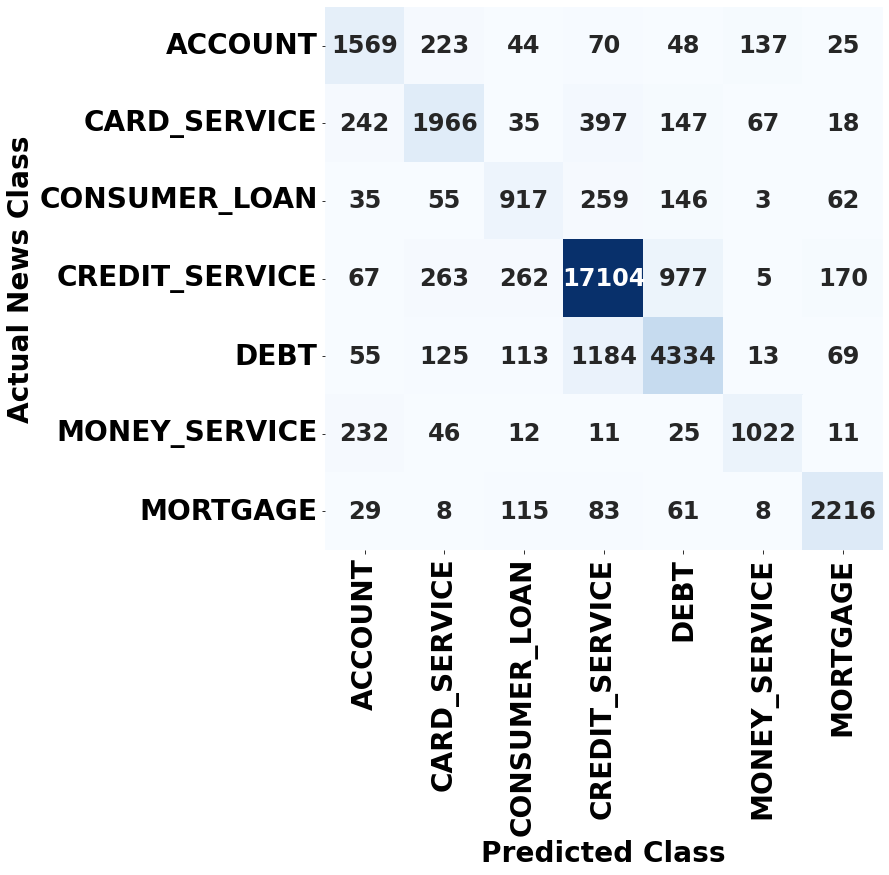

The F1 score of validation set is 0.8295730558220576


<Figure size 432x288 with 0 Axes>

In [26]:
ticklabels = pd.read_csv("encoding_label_dict_token.csv", names = ["name", "label"], header = 0)
ticklabels = ticklabels["name"].tolist()

plot_confusion_matrix(labels_test, val_preds, ticklabels)